In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
pd.set_option('display.max_columns', None)
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.options.mode.chained_assignment = None

In [12]:
class color:
    PURPLE = '\033[95m'
    CYAN = '\033[96m'
    DARKCYAN = '\033[36m'
    BLUE = '\033[94m'
    GREEN = '\033[92m'
    YELLOW = '\033[93m'
    RED = '\033[91m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'
    GREYBACKBLACK =  '\033[0;30;47m'
    END = '\033[0m'

In [5]:
df = pd.read_csv("/content/data_ANDAT.csv")
df.head()

,DATE,Tx
0,1/01/2022,34.4
1,1/02/2022,34.3
2,1/03/2022,32.8
3,1/04/2022,33.0
4,1/05/2022,32.0


In [6]:
df_final = df.copy()

In [7]:
df_final = df_final.set_index('DATE')
df_final.index = pd.to_datetime(df_final.index)

In [9]:
df_final.head()

,Tx
DATE,
2022-01-01,34.4
2022-01-02,34.3
2022-01-03,32.8
2022-01-04,33.0
2022-01-05,32.0


<function matplotlib.pyplot.show(close=None, block=None)>

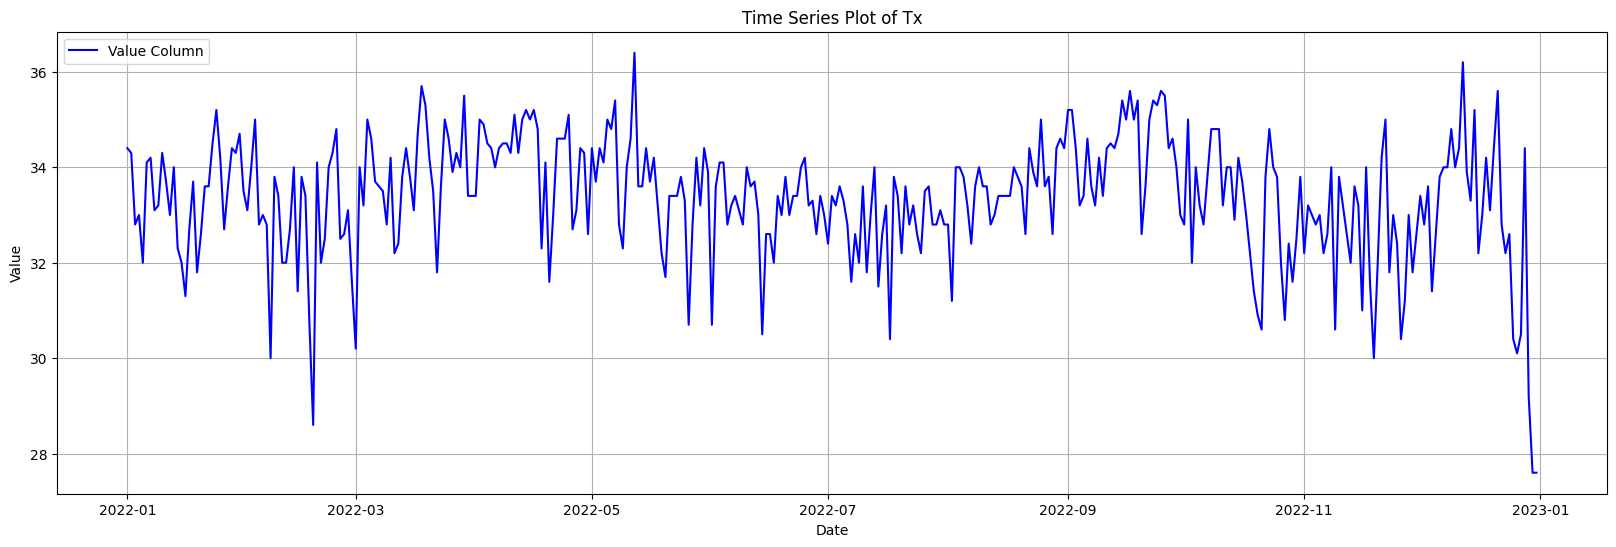

In [10]:
plt.figure(figsize=(20,6))
plt.plot(df_final.index, df_final['Tx'], color = 'b', label = 'Value Column')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Time Series Plot of Tx')
plt.legend()
plt.grid(True)
plt.show

# CHECKING OUTLIER

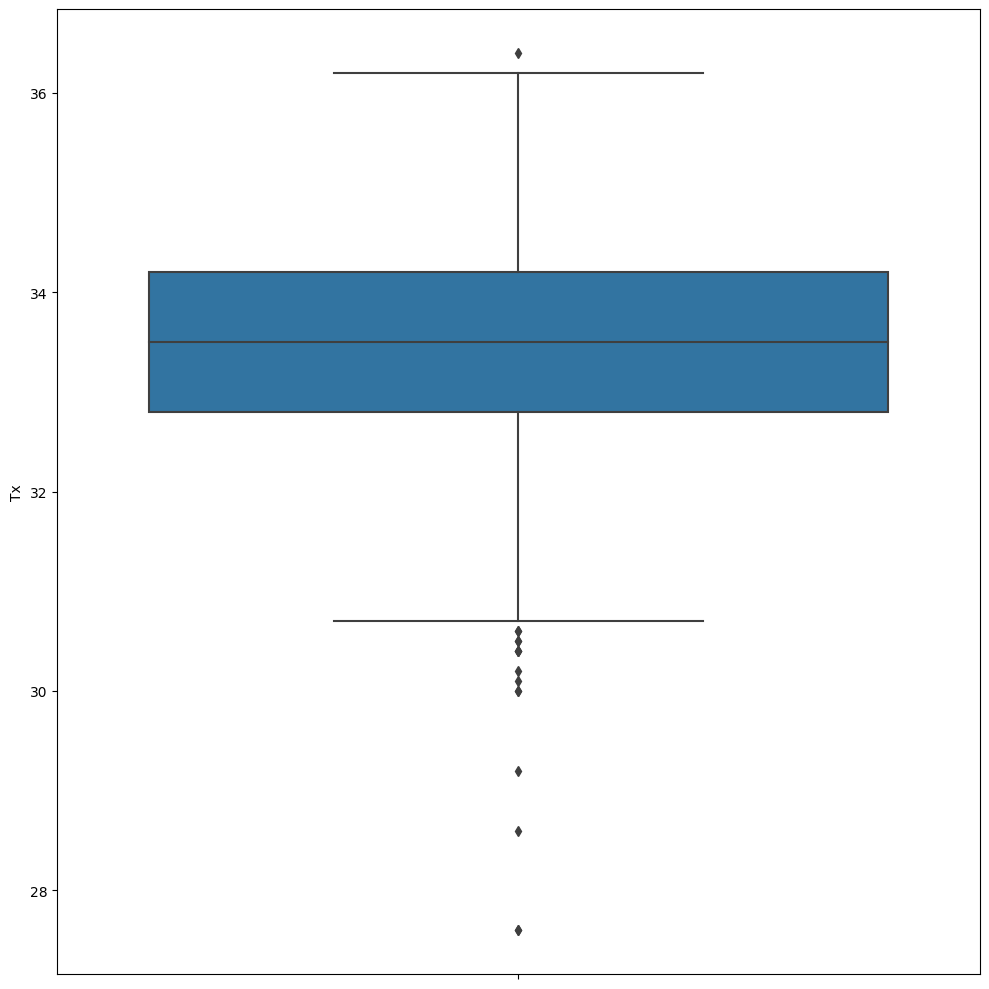

In [11]:
df_out = df_final.copy()

data_outlier = ['Tx']
plt.figure(figsize=(10,10))
for i in range(0, len(data_outlier)):
  plt.subplot(1,len(data_outlier),i+1)
  sns.boxplot(y=df_out[data_outlier[i]])
  plt.tight_layout()

# OUTLIER REMOVING

In [13]:
for i in range(len(data_outlier)):
  Q1 = np.quantile(df_out[data_outlier[i]], .25)
  Q3 = np.quantile(df_out[data_outlier[i]], .75)
  IQR = Q3 - Q1
  min_IQR = Q1 - 1.5 * IQR
  max_IQR = Q3 + 1.5 * IQR
  print("Mendeteksi Outliers pada kolom", color.BOLD+"{0}".format(data_outlier[i])+color.END)
  print("Batas min_IQR: ",min_IQR)
  print("Batas max_IQR: ",max_IQR)

df_out = df_out[(df_out['Tx'] >= min_IQR) & (df_out['Tx'] <= max_IQR)]
df_out

Mendeteksi Outliers pada kolom Tx
Batas min_IQR:  30.69999999999999
Batas max_IQR:  36.30000000000001


,Tx
DATE,
2022-01-01,34.4
2022-01-02,34.3
2022-01-03,32.8
2022-01-04,33.0
2022-01-05,32.0
...,...
2022-12-21,35.6
2022-12-22,32.8
2022-12-23,32.2


In [14]:
df_out['Tx'].describe()

count    349.000000
mean      33.510602
std        1.042586
min       30.700000
25%       32.800000
50%       33.600000
75%       34.300000
max       36.200000
Name: Tx, dtype: float64

In [15]:
train = df_out.loc[df_out.index < '2022-10-31']
test = df_out.loc[df_out.index >= '2022-10-31']

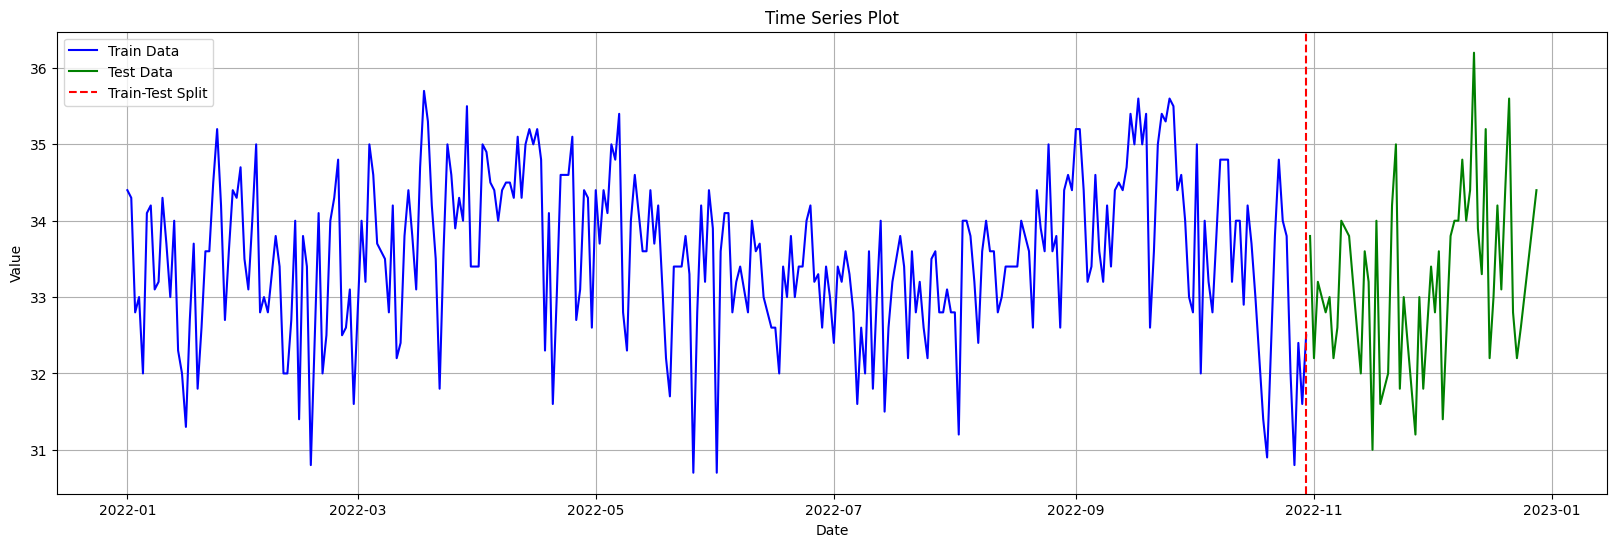

In [16]:
plt.figure(figsize=(20, 6))

# Plot the training data
plt.plot(train.index, train['Tx'], color='b', label='Train Data')

# Plot the test data with a different color
plt.plot(test.index, test['Tx'], color='g', label='Test Data')

plt.axvline(x=train.index[-1], color='r', linestyle='--', label='Train-Test Split')  # Vertical line at the end of train data

plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Time Series Plot')
plt.legend()
plt.grid(True)
plt.show()

In [18]:
def create_features(df_out):
    """
    Create time series features based on time series index.
    """
    df_out = df_out.copy()
    df_out['dayofyear'] = df_out.index.dayofyear
    df_out['month'] = df_out.index.month
    df_out['year'] = df_out.index.year
    return df_out

df_out = create_features(df_out)

In [19]:
train = create_features(train)
test = create_features(test)

FEATURES = ['dayofyear', 'month', 'year']
TARGET = 'Tx'

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

In [24]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, cross_val_predict, TimeSeriesSplit, KFold, cross_val_score

In [25]:
seed = 35


xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    max_depth=49,
    learning_rate=0.1,
    n_estimators=1200,
    min_child_weight=2,
    gamma=1,
    subsample=0.8,
    colsample_bytree=0.4,
    scale_pos_weight=1,
    random_state=seed
)

tscv = TimeSeriesSplit(n_splits=10)
for train_index, val_index in tscv.split(X_train):
    X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
    y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]

    xgb_model.fit(X_train_fold, y_train_fold)

# Make Predictions
y_pred = xgb_model.predict(X_test)

# Evaluate the Model
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

def smape(actual, forecast):
    return 100 * np.mean(2 * np.abs(actual - forecast) / (np.abs(actual) + np.abs(forecast)))

smape_score = smape(y_test, y_pred)
print(f"SMAPE Score: {smape_score}")

Mean Squared Error: 1.2369160248019913
SMAPE Score: 2.655642510210067


In [37]:
data_test = pd.read_csv("/content/data_test.csv")
data_test.head()

,date,Tx
0,1/1/2023,31.0
1,1/2/2023,31.5
2,1/3/2023,32.8
3,1/4/2023,34.0
4,1/5/2023,34.2


In [38]:
data_test = data_test.drop(columns=['Tx'], axis = 1)

In [39]:
data_test = data_test.set_index('date')
data_test.index = pd.to_datetime(data_test.index)

In [40]:
data_test = create_features(data_test)

In [41]:
y_pred = xgb_model.predict(data_test)
y_pred_series = pd.DataFrame(y_pred, columns=['Tx'])
y_pred_series['id'] = list(range(len(y_pred_series)))
y_pred_series['Tx'], y_pred_series['id'] = y_pred_series['id'], y_pred_series['Tx']
y_pred_series.columns = ['id', 'Tx']

y_pred_series

,id,Tx
0,0,33.961491
1,1,33.961491
2,2,33.399940
3,3,33.399940
4,4,33.399940
...,...,...
360,360,33.084126
361,361,33.084126
362,362,33.084126
363,363,33.084126


In [42]:
y_pred_series.to_csv('forecast_2023.csv', index = False)